# 9.3 Neural Network Classifiers
Name: Joi Chu-Ketterer <br>Date: 11/3/19<br>Course: DSC550 - Data Mining
            
      

In [1]:
import json_lines
import pandas as pd
import numpy as np

__Data Understanding__

In this section, the data is imported and then a histogram is created to understand the distribution of comments. Additionally, since the file size is so large and model training took a lot of time, a separate dataframe was created with a random sample of 20,000 entries from the original dataset. 

In [2]:
df = pd.read_json('categorized.jsonl', lines=True)

In [3]:
df.head(5)

,cat,txt
0,sports,Barely better than Gabbert? He was significant...
1,sports,Fuck the ducks and the Angels! But welcome to ...
2,sports,Should have drafted more WRs.\n\n- Matt Millen...
3,sports,[Done](https://i.imgur.com/2YZ90pm.jpg)
4,sports,No!! NOO!!!!!


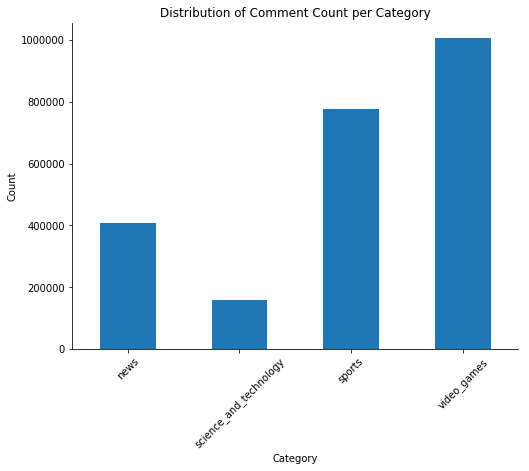

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
labels = df['cat']
df.groupby('cat').txt.count().plot.bar(ylim=0)
plt.xticks(rotation=45)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Distribution of Comment Count per Category')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [31]:
df_new = df.sample(n = 20000)

df_new.head(5)

,cat,txt
1058120,video_games,well gp did this before he even started buying...
472812,video_games,LOLOLOL!!!!!....Me too...
322627,video_games,Genesis?
249043,sports,This is the closest u can get
1503309,news,"Hey it's me, your service man"


__1. Neural Network Classifier with Scikit__

Using the multi-label classifier dataset from earlier exercises (categorized-comments.jsonl in the reddit folder), fit a neural network classifier using scikit-learn. Use the code found in chapter 12 of the Applied Text Analysis with Python book as a guideline. Report the accuracy, precision, recall, F1-score, and confusion matrix.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

In [32]:
# to clean and reduce the number of phrases the model will need to analyze, 
# the comments will be stripped of stop words and tokenized 

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
tf = TfidfVectorizer(lowercase=True,
                     stop_words='english',
                     ngram_range = (1,1),
                     tokenizer = token.tokenize)
text_tf= tf.fit_transform(df_new['txt'])

In [42]:
# as with any model, a training and testing set will be created

X_train, X_test, y_train, y_test = train_test_split(
    text_tf, df_new['cat'], test_size=0.3, random_state=1)

# this istantiates the model itself
model_mlp = MLPClassifier(hidden_layer_sizes = [200,50], verbose = False).fit(X_train, y_train)

In [43]:
# this calculates the predicted values 

predicted= model_mlp.predict(X_test)

In [44]:
accuracy = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average = None)
precision = precision_score(y_test, predicted, average = None)
recall = recall_score(y_test, predicted, average = None)

print('Accuracy: ', accuracy)
print('Precision: ', precision.mean())
print('Recall: ', recall.mean())
print('F1: ', f1.mean())

Accuracy:  0.5366666666666666
Precision:  0.6302962072069471
Recall:  0.4210223421591532
F1:  0.4168595936162209


In [231]:
matrix_mlp = confusion_matrix(y_test, predicted)
matrix_mlp

array([[21,  0,  9, 18],
       [ 7,  1,  7,  6],
       [14,  0, 60, 30],
       [11,  0, 37, 79]])

''

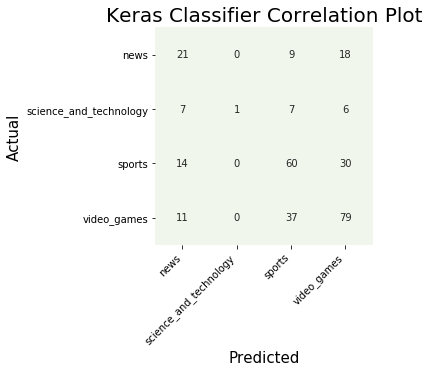

In [235]:
import seaborn as sns

map_label = list(label.inverse_transform([0, 1, 2, 3]))


matrix_mlp_cm = pd.DataFrame(matrix_mlp)


ax = sns.heatmap(matrix_mlp_cm, 
           annot=True,
            vmin=-1, vmax=1, center=0,
           cbar=False, 
           fmt="d",
           cmap=sns.cubehelix_palette(n_colors = 1, start = 0.6, dark =0, light = 0.95),
            square=True,
            xticklabels = map_label,
            yticklabels = map_label )


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Keras Classifier Correlation Plot', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
;

__2. Neural Network Classifier with Keras__

Using the multi-label classifier dataset from earlier exercises (categorized-comments.jsonl in the reddit folder), fit a neural network classifier using Keras. Use the code found in chapter 12 of the Applied Text Analysis with Python book as a guideline. Report the accuracy, precision, recall, F1-score, and confusion matrix.

In [49]:
from keras.layers import Dense
from keras.models import Sequential
from keras import metrics
from keras import layers

Using TensorFlow backend.


In [152]:
# this creates the neural network layer by layer 

input_dim = X_train.shape[1]

def baseline():
    model_keras = Sequential()
    model_keras.add(layers.Dense(10, input_dim = input_dim, activation = 'relu'))
    model_keras.add(layers.Dense(5, activation= 'relu'))
    model_keras.add(layers.Dense(4, activation = 'softmax'))

    model_keras.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = 'adam', 
                 metrics = ["accuracy"])
    
    return model_keras

In [124]:
# without encoding the category column, the model was running into issues
# this is similar to the factor method in R

from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
df_new['cat2'] = label.fit_transform(df_new['cat'])

In [74]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    text_tf, df_new['cat2'], test_size=0.3, random_state=1)

In [153]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# this instantiates the neural model

estimator = KerasClassifier(build_fn = baseline, 
                            epochs=100, 
                            batch_size=10, 
                            verbose=False)

In [154]:
results = cross_val_score(estimator, text_tf, df_new['cat2'], cv = 2, error_score='raise')
model_keras.fit(text_tf, df_new['cat2'])

Epoch 1/1
1000/1000 [==============================] - 0s 492us/step - loss: 0.1903 - accuracy: 0.9260


In [156]:
predicted_keras = model_keras.predict(X_test2)

predicted_keras

array([[9.5036787e-01, 1.6499763e-04, 6.3551804e-03, 4.3112110e-02],
       [3.8336267e-04, 1.9466106e-04, 9.5441169e-04, 9.9846750e-01],
       [5.6176312e-05, 4.3804430e-05, 7.5005999e-05, 9.9982506e-01],
       ...,
       [5.0809127e-01, 2.3279260e-01, 1.4794721e-01, 1.1116898e-01],
       [1.4209483e-02, 6.2989532e-03, 7.0047326e-02, 9.0944421e-01],
       [9.5689440e-01, 5.3029675e-03, 1.8903334e-02, 1.8899344e-02]],
      dtype=float32)

In [157]:
# predict classes for test set

class_predict = model_keras.predict_classes(X_test2)

In [164]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test2, class_predict)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test2, class_predict, average = None)
print('Precision: %f' % precision.mean())
# recall: tp / (tp + fn)
recall = recall_score(y_test2, class_predict, average = None)
print('Recall: %f' % recall.mean())
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test2, class_predict, average = None)
print('F1 score: %f' % f1.mean())

Accuracy: 0.933333
Precision: 0.940631
Recall: 0.863418
F1 score: 0.886781


In [173]:
matrix_keras = confusion_matrix(y_test2, class_predict)
matrix_keras

array([[ 46,   0,   2,   0],
       [  5,  12,   3,   1],
       [  0,   0, 101,   3],
       [  1,   0,   5, 121]])

''

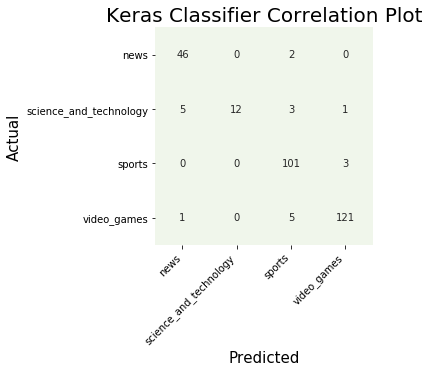

In [229]:
import seaborn as sns

map_label = list(label.inverse_transform([0, 1, 2, 3]))


matrix_keras_cm = pd.DataFrame(matrix_keras)


ax = sns.heatmap(matrix_keras_cm, 
           annot=True,
            vmin=-1, vmax=1, center=0,
           cbar=False, 
           fmt="d",
           cmap=sns.cubehelix_palette(n_colors = 1, start = 0.6, dark =0, light = 0.95),
            square=True,
            xticklabels = map_label,
            yticklabels = map_label)


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Keras Classifier Correlation Plot', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
;

3. Classifying Images

In chapter 20 of the Machine Learning with Python Cookbook, implement the code found in section 20.15 classify MSINT images using a convolutional neural network. Report the accuracy of your results.

In [3]:
import numpy as np
from keras.datasets import mnist 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [9]:
#the channels first setting means image data is represented in a 2D array
#the first channel of that array represents the color channels
#[channels][rows][cols] vs  [rows][cols][channels]
#order will vary depending on the type of deep learning library you use 

K.set_image_data_format("channels_first")

In [10]:
np.random.seed(100)

In [11]:
channels = 1
height = 28
width = 28

In [12]:
#this downloads training and testing sets directly from the MNIST database

(data_train, target_train), (data_test, target_test) = mnist.load_data()

In [13]:
data_test.shape, data_train.shape, target_train.shape, target_test.shape

((10000, 28, 28), (60000, 28, 28), (60000,), (10000,))

In [14]:
#the reshapes the datasets to include the features 
#it takes multiple rows of data (each row being a feature) and makes it
#one row and multiple columns

data_test = data_test.reshape(data_test.shape[0], channels, height, width)
data_train = data_train.reshape(data_train.shape[0], channels, height, width)

In [15]:
data_test.shape, data_train.shape

((10000, 1, 28, 28), (60000, 1, 28, 28))

In [16]:
#here we are rescaling the pixels
#this is useful for low contrast photos to improve their quality
#pixel values range from 0 to 255

features_train = data_train/255
features_test = data_test/255

In [17]:
#the encodes the categorical features
#the number of classes' value is taken from the number of channels we have
#we specified this to be 1 earlier
#even earlier than that, we know that the first channel is our color
#channel 

target_train = np_utils.to_categorical(target_train)
target_test = np_utils.to_categorical(target_test)
number_of_classes = target_test.shape[1]

In [18]:
#this instantiates the neural network
#the Sequential() API allows you to create models layer by layer for most problems
#the sequential model API is a way to create deep learning models
#the instance of the sequential class is created
#model layers are created and added to that instance
#not good for model with
# - different input source
# - multiple output destinations
# - models that re-use layers


network = Sequential()

In [19]:
#adding a convolutional layer
#a linear operation using a subset of weights of a dense layer
#nearby inputs are connected with nearby outputs 
#the weights for the convolutions at each location are shares
#since weights are shared, there are fewer weights than in a dense laye r
#followed by non-linear activation function

#create a convultion kernal that is convolved with the layer input to product tensor of outputs
#if the first layer, need the input shape 

network.add(Conv2D(filters = 64,
                  kernel_size = (5, 5),
                  input_shape = (channels, width, height),
                  activation = 'relu'))

In [20]:
#add a maxpooling layer
#this can be minpooling or maxpooling 
#with maxpooling, we are calculating the maximum (largest) value in each 
#patch of the feature map
#basically find the most present feature in the patch rather than the average
#finding the max is good for image classifcation
#features tend to encode the spactial presence of some pattern over different tiles of a feature map 
#more informative to look at the max rather than average precense

network.add(MaxPooling2D(pool_size = (2,2)))

In [21]:
#add the dropout layer
#prevents the model from overfitting
#regularized method that approximates training large number of NN
#during training, random number of layer outputs are randomly ignored/dropped out
#by setting this to 0.5, we saying 50% of the inputs will be set to zero

network.add(Dropout(0.8))

In [22]:
#adding a layer to flatten input
#this reshapes the matrix into a single array (multiple rows into multiple columns)

network.add(Flatten())

In [23]:
#adding fully connected layer of 128 units with the ReLu activation function
#linear operation
#every input is connected to every output by a weight 
#followed by non-linear activation function 
#units = neurons


network.add(Dense(128, activation = 'relu'))

In [25]:
#since we are building the network layer by layer, we will add
#another drop out layer

network.add(Dropout(0.8))

In [26]:
#relu vs sigmoid 
#sigmoid is a special version of softmax that has 0 on negative infinity and 1 on positive inifity 
#relu is as element-wise non-linear function
#non-competitive non-linear
#good for inner layers 
#can lead to less sense solutions
#reduces liklihood of vanishing gradients

#the sigmoid
#maps each input to a non-zero value
#this means each input will have an output and be considered at each layer pass
#even if it is not statistically significant
#vs. relu that can give zero-value output and reduce the number neurons at each pass
#this is lessen the dependence between features 

#softmax is soft, normalized, winner-take-all function
#good for outlayers
#gives probabilities of certain classes occruing
#not that useful for hidden layers 


network.add(Dense(number_of_classes, 
                 activation = 'softmax'))

In [27]:
#with all the layers created, we can compile the network

network.compile(loss = 'categorical_crossentropy',
               optimizer = 'rmsprop',
               metrics = ['accuracy'])

In [28]:
#now to train the model
#batch size is the subset size of training csample

history = network.fit(features_train,
           target_train,
            epochs = 2,
            verbose = 0,
            batch_size = 100,
            validation_data = (features_test, target_test)
           )

history

In [29]:
loss, acc = network.evaluate(features_test, target_test, verbose = 0)
print("model accuracy:" , acc * 100)

model accuracy: 95.96999883651733
